# Import packages

In [6]:
import pandas as pd
from teradataml import *
import ast
import json
import matplotlib.pyplot as plt

from modules.db import TeradataDatabase

from teradataml.dataframe.copy_to import copy_to_sql

from utils import clean_text
from constants import (
JIO_MART_DATASET_MAPPED, MWPD_FULL_DATASET, USDA_TO_CPG, EXTRA_FOOD_DATA, MANUALLY_LABELLED_DATASET, JIO_MART_DATASET, GPC_PATH, TRAIN_VAL_DATA_PATH
)


In [48]:
df = pd.read_csv(TRAIN_VAL_DATA_PATH)
df_lables = df["class"].unique()
df_lables

array(['Vegetables & Fruits', 'Tea, Coffee & Hot Drinks', 'Bakery',
       'Soft Drinks & Juices', 'Tins, Jars & Packets', 'Biscuits & Cakes',
       'Beef & Processed Meat', 'Chocolates, Sweets & Desserts',
       'Poultry', 'Sauces, Dressings & Condiments',
       'Nuts, Dates & Dried Fruits', 'Cleaning Supplies', 'Dairy & Eggs',
       'Chips & Crackers', 'Water', 'Rice, Pasta & Pulses',
       'Personal care, skin & body care', 'Furniture',
       'Cooking Ingredients', 'Vegetables & Herbs',
       'Condiments, Dressings & Marinades', 'Sweets & Desserts',
       'Laundry & Detergents', 'Tea and Coffee', 'Disposables & Napkins',
       'Sugar & Home Baking', 'Perfumes & Deodorants', 'Fruits',
       'Stationary', 'Jams, Spreads & Syrups', nan, 'Baby Care',
       'Chips & crackers', 'Home Appliances', 'Fish',
       'Breakfast Cereals & Bars', 'Hair, Shower, Bath & Soap',
       'Party supplies and gifts', 'Wear', 'Footwear',
       'Candles & Air Fresheners', 'Beef & Lamb Meat', 'P

In [ ]:
def preprocess_keep_symbols(text):
    if pd.isna(text): return ""
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'[^a-z0-9\s\+\-/\.]', ' ', text)
    return ' '.join(text.split())

## MWPD Dataset

In [96]:
mwpd_df = pd.read_csv(MWPD_FULL_DATASET)
mwpd_df.head(5)

,Name,Description,SegmentTitle,FamilyTitle,ClassTitle
0,Sterling Silver Angel Charm,This little angel charm is just heavenly,64000000_Personal Accessories,64010000_Personal Accessories,64010100_Jewellery
1,HP Pavilion 23xi 58.40 cm (23�) IPS Monitor,"Share photos, videos, and games with everyone ...",65000000_Computing,65010000_Computers/Video Games,65010700_Computer/Video Game Peripherals
2,East Carolina Pirates Ladies Personalized Bask...,Feel like a bona fide member of East Carolina ...,67000000_Clothing,67010000_Clothing,67010800_Upper Body Wear/Tops
3,"Tekonsha 90195 P3 Electric Brake Control, 1-4 ...",Receive free shipping on this item. Enter coup...,77000000_Automotive,77010000_Automotive Accessories and Maintenance,77011200_Automotive Maintenance/Repair
4,RN-XV WiFly Module - Wire Antenna,Description: The RN-XV module by Roving Networ...,78000000_Electrical Supplies,78050000_Electronic Communication Components,78050100_Electronic Communication Components


In [94]:
mwpd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16119 entries, 0 to 16118
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          16119 non-null  object
 1   Description   16119 non-null  object
 2   SegmentTitle  16119 non-null  object
 3   FamilyTitle   16119 non-null  object
 4   ClassTitle    16119 non-null  object
dtypes: object(5)
memory usage: 629.8+ KB


In [9]:
mwpd_df = mwpd_df.applymap(preprocess_keep_symbols)

C:\Users\ss255385\AppData\Local\Temp\ipykernel_5096\767690336.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mwpd_df = mwpd_df.applymap(preprocess_keep_symbols)


In [10]:
mwpd_df.isna().sum()

Name            0
Description     0
SegmentTitle    0
FamilyTitle     0
ClassTitle      0
dtype: int64

In [11]:
for col in ["SegmentTitle", "FamilyTitle", "ClassTitle"]:
    print(f"Unique {col}: {mwpd_df[col].nunique()}")

Unique SegmentTitle: 37
Unique FamilyTitle: 76
Unique ClassTitle: 283


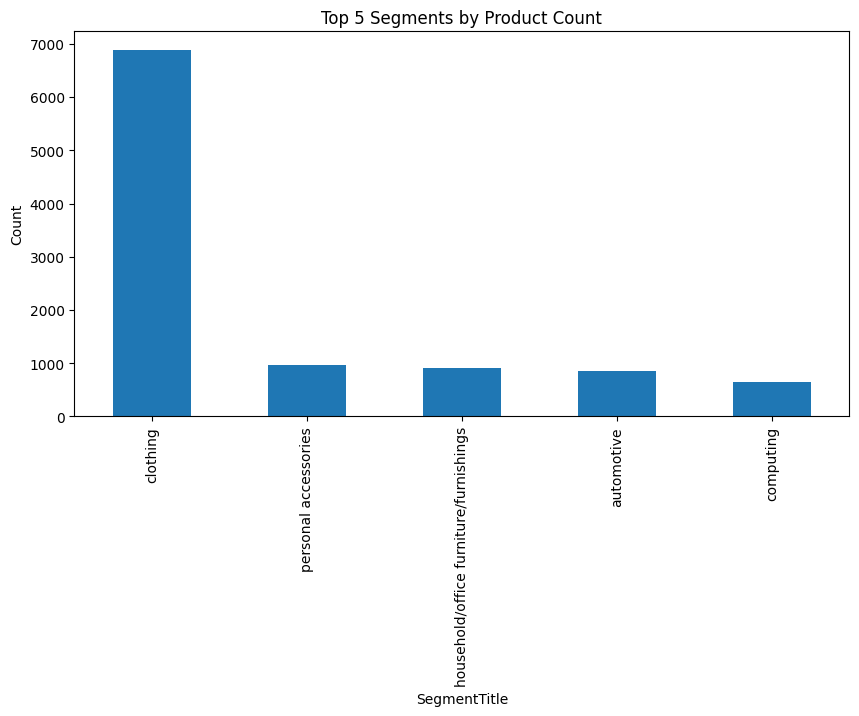

In [78]:
plt.figure(figsize=(10,5))
mwpd_df["SegmentTitle"].value_counts().head(5).plot(kind="bar")
plt.title("Top 5 Segments by Product Count")
plt.ylabel("Count")
plt.show()

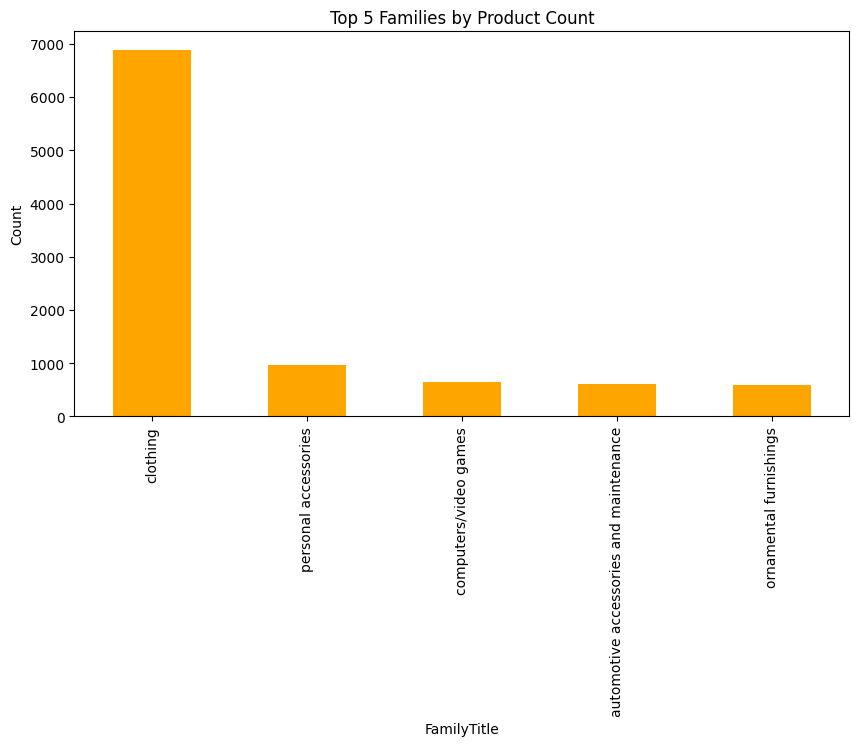

In [79]:
plt.figure(figsize=(10,5))
mwpd_df["FamilyTitle"].value_counts().head(5).plot(kind="bar", color="orange")
plt.title("Top 5 Families by Product Count")
plt.ylabel("Count")
plt.show()

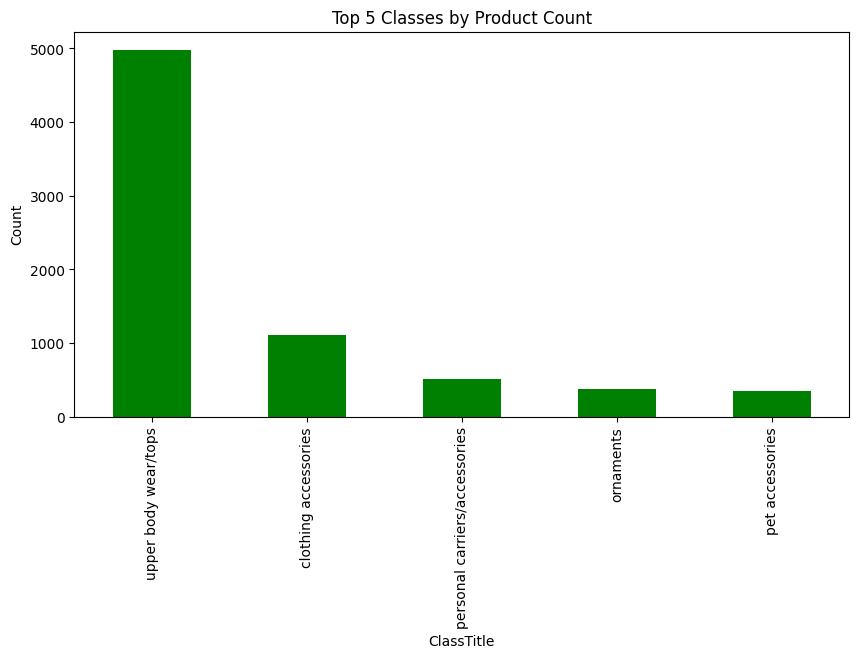

In [80]:
plt.figure(figsize=(10,5))
mwpd_df["ClassTitle"].value_counts().head(5).plot(kind="bar", color="green")
plt.title("Top 5 Classes by Product Count")
plt.ylabel("Count")
plt.show()

In [8]:
seg_fam = mwpd_df.groupby("FamilyTitle")["SegmentTitle"].nunique()
print("\nFamilies mapping to multiple Segments:", (seg_fam > 1).sum())


Families mapping to multiple Segments: 0


In [9]:
fam_cls = mwpd_df.groupby("ClassTitle")["FamilyTitle"].nunique()
print("Classes mapping to multiple Families:", (fam_cls > 1).sum())

Classes mapping to multiple Families: 1


In [19]:
print("\nProducts per Segment (top 5):")
mwpd_df.groupby("SegmentTitle")["Name"].count().sort_values(ascending=False).head(5)


Products per Segment (top 5):


SegmentTitle
clothing                                  6887
personal accessories                       962
household/office furniture/furnishings     910
automotive                                 846
computing                                  642
Name: Name, dtype: int64

In [20]:
print("\nProducts per Segment (lower 5):")
mwpd_df.groupby("SegmentTitle")["Name"].count().sort_values(ascending=False).tail(5)


Products per Segment (lower 5):


SegmentTitle
horticulture plants           26
storage/haulage containers    18
fuels/gases                    7
tool storage/workshop aids     6
lubricants                     2
Name: Name, dtype: int64

In [21]:
print("\nProducts per Family (top 5):")
mwpd_df.groupby("FamilyTitle")["Name"].count().sort_values(ascending=False).head(5)


Products per Family (top 5):


FamilyTitle
clothing                                  6887
personal accessories                       962
computers/video games                      642
automotive accessories and maintenance     617
ornamental furnishings                     595
Name: Name, dtype: int64

In [22]:
print("\nProducts per Family (lower 5):")
mwpd_df.groupby("FamilyTitle")["Name"].count().sort_values(ascending=False).tail(5)


Products per Family (lower 5):


FamilyTitle
stationery/office machinery/occasion supplies variety packs    3
waste management products                                      3
live plants genus a thru g                                     2
lubricants/protective compounds                                2
plants variety packs                                           2
Name: Name, dtype: int64

In [23]:
print("\nProducts per Class (top 5):")
mwpd_df.groupby("ClassTitle")["Name"].count().sort_values(ascending=False).head(5)


Products per Class (top 5):


ClassTitle
upper body wear/tops             4979
clothing accessories             1109
personal carriers/accessories     513
ornaments                         370
pet accessories                   350
Name: Name, dtype: int64

In [24]:
print("\nProducts per Class (lower 5):")
mwpd_df.groupby("ClassTitle")["Name"].count().sort_values(ascending=False).tail(5)


Products per Class (lower 5):


ClassTitle
role play toys                             1
beverages variety packs                    1
automotive trailers/trailer accessories    1
tools/equipment hand variety packs         1
toys/games variety packs                   1
Name: Name, dtype: int64

## Jio Mart

In [26]:
jio_mart_df = pd.read_csv(JIO_MART_DATASET)
jio_mart_df = jio_mart_df.loc[~jio_mart_df['items'].isna(), :]
jio_mart_df = jio_mart_df.drop(columns=['href', 'price'])
jio_mart_df.rename(columns={'items': 'product name'}, inplace=True)
jio_mart_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162280 entries, 0 to 162312
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      162280 non-null  object
 1   sub_category  162280 non-null  object
 2   product name  162280 non-null  object
dtypes: object(3)
memory usage: 5.0+ MB


In [5]:
jio_mart_df = pd.read_csv(JIO_MART_DATASET)
jio_mart_df.head()

,category,sub_category,href,items,price
0,Groceries,Fruits & Vegetables,https://www.jiomart.com/c/groceries/fruits-veg...,Fresh Dates (Pack) (Approx 450 g - 500 g),109.0
1,Groceries,Fruits & Vegetables,https://www.jiomart.com/c/groceries/fruits-veg...,Tender Coconut Cling Wrapped (1 pc) (Approx 90...,49.0
2,Groceries,Fruits & Vegetables,https://www.jiomart.com/c/groceries/fruits-veg...,Mosambi 1 kg,69.0
3,Groceries,Fruits & Vegetables,https://www.jiomart.com/c/groceries/fruits-veg...,Orange Imported 1 kg,125.0
4,Groceries,Fruits & Vegetables,https://www.jiomart.com/c/groceries/fruits-veg...,Banana Robusta 6 pcs (Box) (Approx 800 g - 110...,44.0


In [28]:
jio_mart_df_cateogires = jio_mart_df["category"].nunique()
jio_mart_df_cateogires

6

In [29]:
jio_mart_df_sub_cateogires = jio_mart_df["sub_category"].nunique()
jio_mart_df_sub_cateogires

69

In [60]:
jio_mart_df.head()

,category,sub_category,product name
0,Groceries,Fruits & Vegetables,Fresh Dates (Pack) (Approx 450 g - 500 g)
1,Groceries,Fruits & Vegetables,Tender Coconut Cling Wrapped (1 pc) (Approx 90...
2,Groceries,Fruits & Vegetables,Mosambi 1 kg
3,Groceries,Fruits & Vegetables,Orange Imported 1 kg
4,Groceries,Fruits & Vegetables,Banana Robusta 6 pcs (Box) (Approx 800 g - 110...


In [30]:
jio_mart_df.isna().sum()

category        0
sub_category    0
product name    0
dtype: int64

In [9]:
jio_mart_df_mapped = pd.read_csv(JIO_MART_DATASET_MAPPED)

In [10]:
jio_mart_df_mapped.isna().sum()

category             0
sub_category         0
product name         0
Segment           4243
Family            4243
Class           106812
Brick           162280
dtype: int64

In [11]:
jio_mart_df_mapped.head()

,category,sub_category,product name,Segment,Family,Class,Brick
0,Groceries,Fruits & Vegetables,Fresh Dates (Pack) (Approx 450 g - 500 g),Food/Beverage,Fruits/Vegetables Fresh Cut,NaN,NaN
1,Groceries,Fruits & Vegetables,Tender Coconut Cling Wrapped (1 pc) (Approx 90...,Food/Beverage,Fruits/Vegetables Fresh Cut,NaN,NaN
2,Groceries,Fruits & Vegetables,Mosambi 1 kg,Food/Beverage,Fruits/Vegetables Fresh Cut,NaN,NaN
3,Groceries,Fruits & Vegetables,Orange Imported 1 kg,Food/Beverage,Fruits/Vegetables Fresh Cut,NaN,NaN
4,Groceries,Fruits & Vegetables,Banana Robusta 6 pcs (Box) (Approx 800 g - 110...,Food/Beverage,Fruits/Vegetables Fresh Cut,NaN,NaN


In [125]:
jio_mart_df_mapped.iloc[162103]

category                                                   Beauty
sub_category                                       Men's Grooming
product name    Urban Gabru Beard Oil - Menthol Fresh with Ora...
Segment                              Beauty/Personal Care/Hygiene
Family                                  Personal Hygiene Products
Class                                    General Personal Hygiene
Brick                                                         NaN
Name: 162103, dtype: object

In [ ]:
# jio_mart_df_mapped = jio_mart_df_mapped.applymap(preprocess_keep_symbols)

C:\Users\ss255385\AppData\Local\Temp\ipykernel_5096\3092287498.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  jio_mart_df_mapped = jio_mart_df_mapped.applymap(preprocess_keep_symbols)


In [97]:
for col in ["Segment", "Family", "Class", "Brick"]:
    print(f"Unique {col}: {jio_mart_df_mapped[col].nunique()}")

Unique Segment: 23
Unique Family: 39
Unique Class: 25
Unique Brick: 0


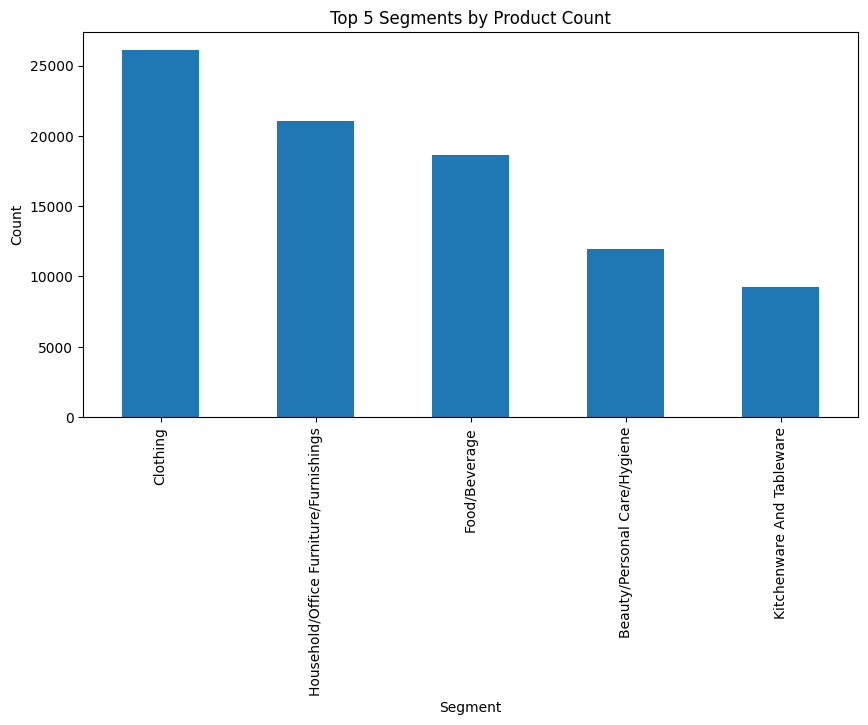

In [81]:
plt.figure(figsize=(10,5))
jio_mart_df_mapped["Segment"].value_counts().head(5).plot(kind="bar")
plt.title("Top 5 Segments by Product Count")
plt.ylabel("Count")
plt.show()

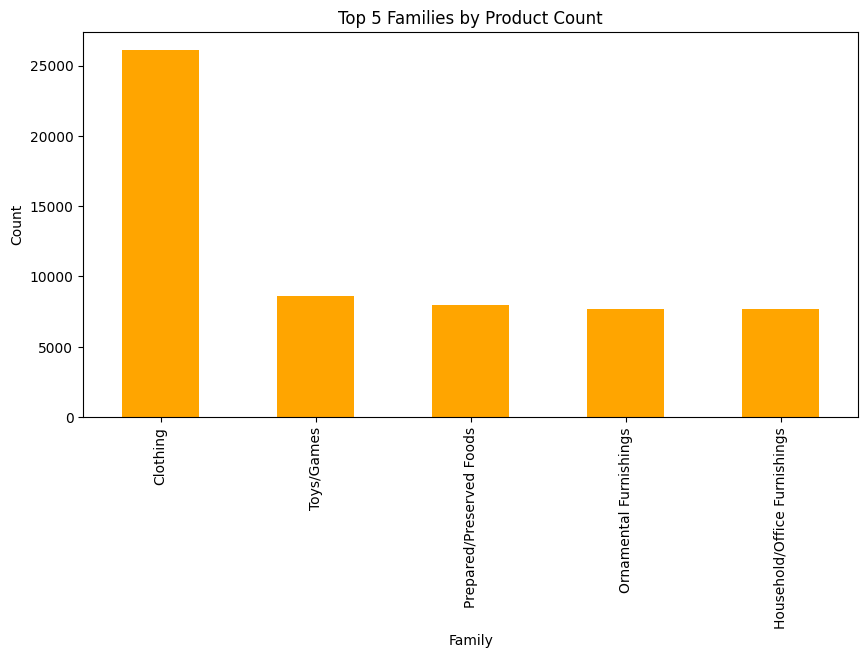

In [82]:
plt.figure(figsize=(10,5))
jio_mart_df_mapped["Family"].value_counts().head(5).plot(kind="bar", color="orange")
plt.title("Top 5 Families by Product Count")
plt.ylabel("Count")
plt.show()

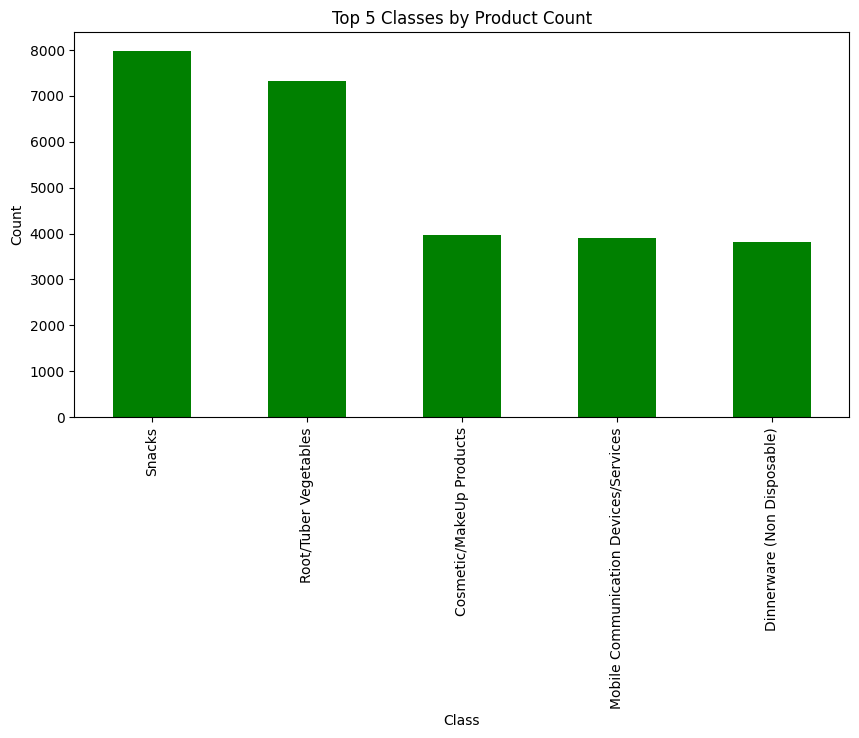

In [89]:
plt.figure(figsize=(10,5))
jio_mart_df_mapped["Class"].value_counts().head(5).plot(kind="bar", color="green")
plt.title("Top 5 Classes by Product Count")
plt.ylabel("Count")
plt.show()

In [54]:
print("\nProducts per Segment (top 5):")
jio_mart_df_mapped.groupby("Segment")["product name"].count().sort_values(ascending=False).head(5)


Products per Segment (top 5):


Segment
Clothing                                  26087
Household/Office Furniture/Furnishings    21030
Food/Beverage                             18631
Beauty/Personal Care/Hygiene              11918
Kitchenware And Tableware                  9263
Name: product name, dtype: int64

In [53]:
print("\nProducts per Segment (lower 5):")
jio_mart_df_mapped.groupby("Segment")["product name"].count().sort_values(ascending=False).tail(5)


Products per Segment (lower 5):


Segment
Plumbing/Heating/Ventilation/Air Conditioning    231
Safety/Security/Surveillance                      61
Building Products                                 32
Healthcare                                        22
Sports Equipment                                   3
Name: product name, dtype: int64

In [56]:
print("\nProducts per Family (top 5):")
jio_mart_df_mapped.groupby("Family")["product name"].count().sort_values(ascending=False).head(5)


Products per Family (top 5):


Family
Clothing                        26087
Toys/Games                       8594
Prepared/Preserved Foods         7986
Ornamental Furnishings           7685
Household/Office Furnishings     7682
Name: product name, dtype: int64

In [57]:
print("\nProducts per Family (lower 5):")
jio_mart_df_mapped.groupby("Family")["product name"].count().sort_values(ascending=False).tail(5)


Products per Family (lower 5):


Family
Building Products                                32
Plumbing/Heating/Ventilation/Air Conditioning    30
Beauty/Personal Care/Hygiene Variety Packs       23
Medical Devices                                  22
Sports Equipment                                  3
Name: product name, dtype: int64

In [58]:
print("\nProducts per Class (top 5):")
jio_mart_df_mapped.groupby("Class")["product name"].count().sort_values(ascending=False).head(5)


Products per Class (top 5):


Class
Snacks                                   7986
Root/Tuber Vegetables                    7318
Cosmetic/MakeUp Products                 3962
Mobile Communication Devices/Services    3895
Dinnerware (Non Disposable)              3816
Name: product name, dtype: int64

In [59]:
print("\nProducts per Class (lower 5):")
jio_mart_df_mapped.groupby("Class")["product name"].count().sort_values(ascending=False).tail(5)


Products per Class (lower 5):


Class
General Personal Hygiene                         68
Painting                                         31
Plumbing/Heating/Ventilation/Air Conditioning    30
Medical Devices                                  22
Ornaments                                        15
Name: product name, dtype: int64

## Food Product Image Dataset

In [111]:
extra_food_df = pd.read_csv(EXTRA_FOOD_DATA)
extra_food_df.tail()

,Name,SegmentTitle,FamilyTitle,ClassTitle,BrickTitle
245,Bio Garten Kresse,Food/Beverage,Leaf Vegetables - Unprepared/Unprocessed (Fresh),Single Leaf Salad Greens,Watercress
246,Pflücksalat,Food/Beverage,Leaf Vegetables - Unprepared/Unprocessed (Fresh),Loose Leaf/Multileaf Salad Greens,Loose Leaf/Multileaf Lettuce Other
247,Cornetto,Food/Beverage,Prepared/Preserved Foods,Desserts/Desserts Substitutes/Dessert Sauces/T...,Ice Cream/Ice Novelties (Frozen)
248,Magnum Mini,Food/Beverage,Prepared/Preserved Foods,Desserts/Desserts Substitutes/Dessert Sauces/T...,Ice Cream/Ice Novelties (Frozen)
249,Himbeeren,Food/Beverage,Fruits - Unprepared/Unprocessed (Frozen),Fruits - Unprepared/Unprocessed (Frozen),Fruit - Unprepared/Unprocessed (Frozen)


In [113]:
extra_food_df.iloc[50]

Name                             Dallmanns Ingwer-Salbei Bonbons"
SegmentTitle                                        Food/Beverage
FamilyTitle               Confectionery/Sugar Sweetening Products
ClassTitle                                 Confectionery Products
BrickTitle      Sugar Candy/Sugar Candy Substitutes Confectionery
Name: 50, dtype: object

In [107]:
extra_food_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          250 non-null    object
 1   SegmentTitle  250 non-null    object
 2   FamilyTitle   250 non-null    object
 3   ClassTitle    250 non-null    object
 4   BrickTitle    250 non-null    object
dtypes: object(5)
memory usage: 9.9+ KB


In [ ]:
extra_food_df.isna().sum()

In [110]:
for col in ["SegmentTitle", "FamilyTitle", "ClassTitle", "BrickTitle"]:
    print(f"Unique {col}: {extra_food_df[col].nunique()}")

Unique SegmentTitle: 1
Unique FamilyTitle: 19
Unique ClassTitle: 62
Unique BrickTitle: 100


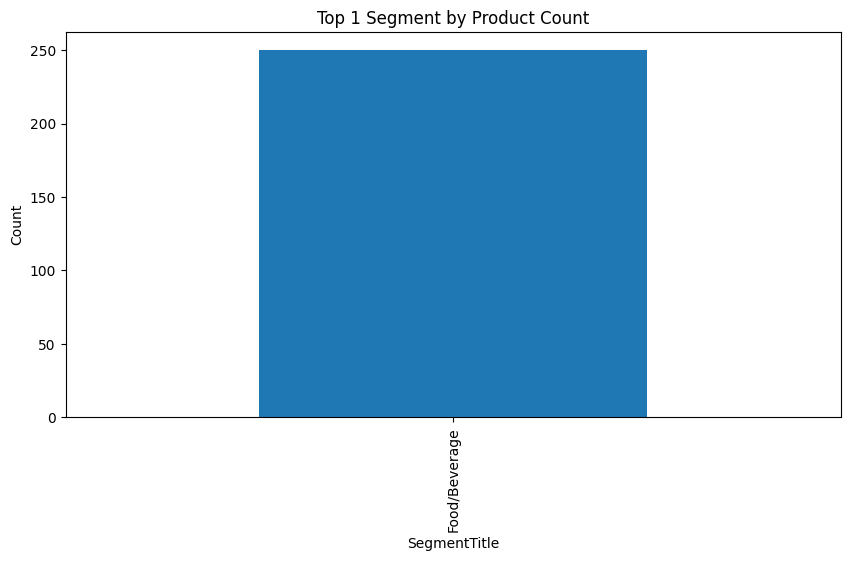

In [74]:
plt.figure(figsize=(10,5))
extra_food_df["SegmentTitle"].value_counts().head(10).plot(kind="bar")
plt.title("Top 1 Segment by Product Count")
plt.ylabel("Count")
plt.show()

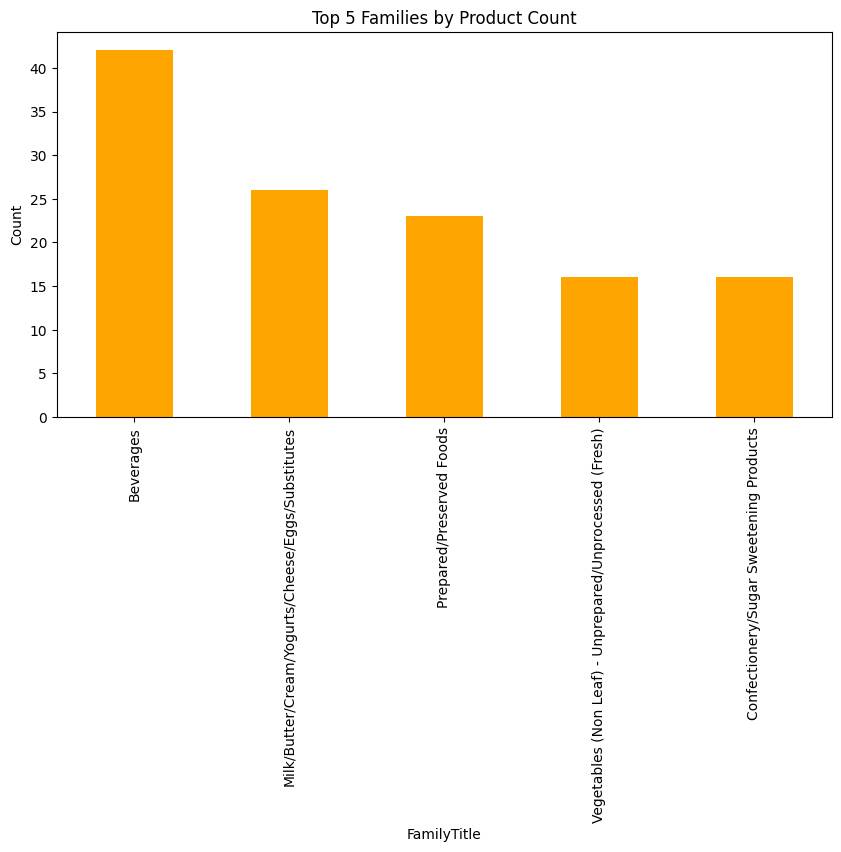

In [85]:
plt.figure(figsize=(10,5))
extra_food_df["FamilyTitle"].value_counts().head(5).plot(kind="bar", color="orange")
plt.title("Top 5 Families by Product Count")
plt.ylabel("Count")
plt.show()

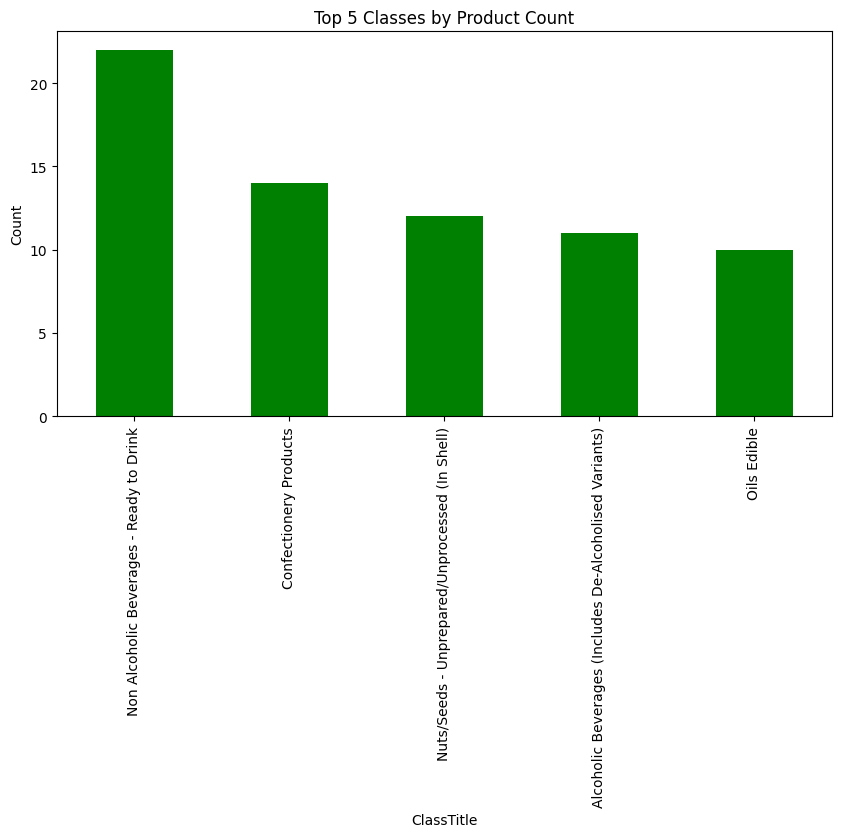

In [86]:
plt.figure(figsize=(10,5))
extra_food_df["ClassTitle"].value_counts().head(5).plot(kind="bar", color="green")
plt.title("Top 5 Classes by Product Count")
plt.ylabel("Count")
plt.show()

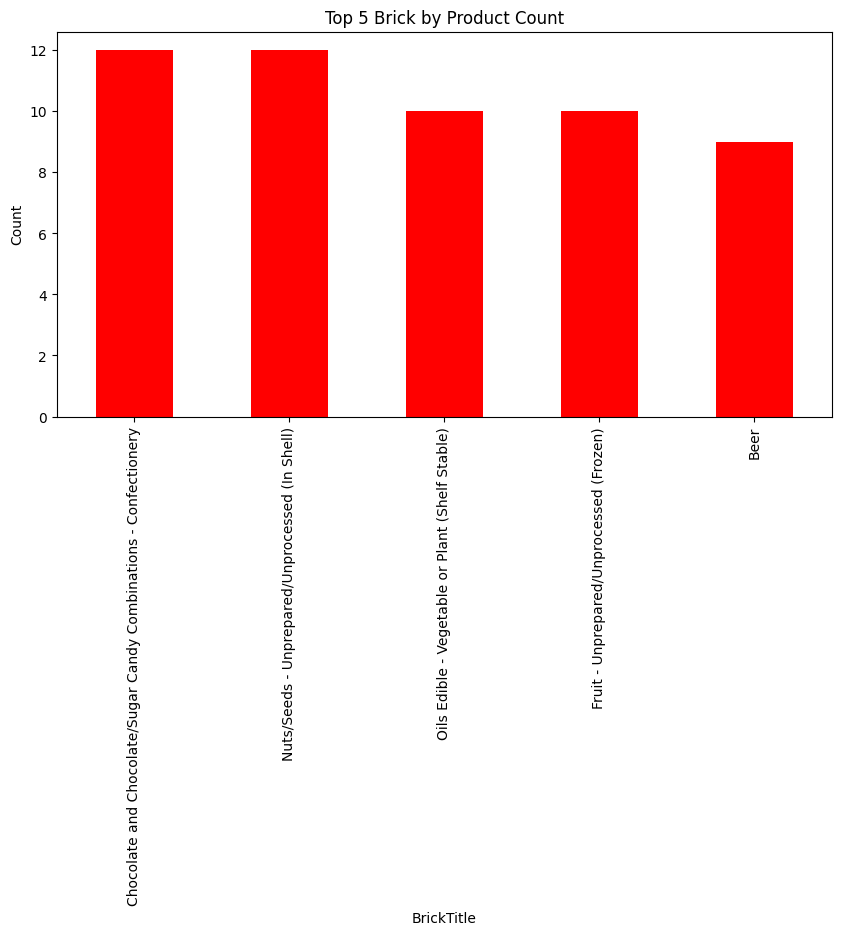

In [90]:
plt.figure(figsize=(10,5))
extra_food_df["BrickTitle"].value_counts().head(5).plot(kind="bar", color="red")
plt.title("Top 5 Brick by Product Count")
plt.ylabel("Count")
plt.show()

In [68]:
print("\nProducts per Segment (top 5):")
extra_food_df.groupby("SegmentTitle")["Name"].count().sort_values(ascending=False).head(5)


Products per Segment (top 5):


SegmentTitle
Food/Beverage    250
Name: Name, dtype: int64

In [69]:
print("\nProducts per Segment (lower 5):")
extra_food_df.groupby("SegmentTitle")["Name"].count().sort_values(ascending=False).tail(5)


Products per Segment (lower 5):


SegmentTitle
Food/Beverage    250
Name: Name, dtype: int64

In [70]:
print("\nProducts per Family (top 5):")
extra_food_df.groupby("FamilyTitle")["Name"].count().sort_values(ascending=False).head(5)


Products per Family (top 5):


FamilyTitle
Beverages                                                 42
Milk/Butter/Cream/Yogurts/Cheese/Eggs/Substitutes         26
Prepared/Preserved Foods                                  23
Confectionery/Sugar Sweetening Products                   16
Vegetables (Non Leaf) - Unprepared/Unprocessed (Fresh)    16
Name: Name, dtype: int64

In [71]:
print("\nProducts per Family (lower 5):")
extra_food_df.groupby("FamilyTitle")["Name"].count().sort_values(ascending=False).tail(5)


Products per Family (lower 5):


FamilyTitle
Leaf Vegetables - Unprepared/Unprocessed (Fresh)      9
Meat/Poultry/Other Animals                            8
Fruits/Vegetables/Nuts/Seeds Prepared/Processed       7
Fruits - Unprepared/Unprocessed (Shelf Stable)        2
Vegetables - Unprepared/Unprocessed (Shelf Stable)    1
Name: Name, dtype: int64

In [72]:
print("\nProducts per Class (top 5):")
extra_food_df.groupby("ClassTitle")["Name"].count().sort_values(ascending=False).head(5)


Products per Class (top 5):


ClassTitle
Non Alcoholic Beverages - Ready to Drink                  22
Confectionery Products                                    14
Nuts/Seeds - Unprepared/Unprocessed (In Shell)            12
Alcoholic Beverages (Includes De-Alcoholised Variants)    11
Fruits - Unprepared/Unprocessed (Frozen)                  10
Name: Name, dtype: int64

In [73]:
print("\nProducts per Bricks (top 5):")
extra_food_df.groupby("ClassTitle")["Name"].count().sort_values(ascending=False).head(5)


Products per Bricks (top 5):


ClassTitle
Non Alcoholic Beverages - Ready to Drink                  22
Confectionery Products                                    14
Nuts/Seeds - Unprepared/Unprocessed (In Shell)            12
Alcoholic Beverages (Includes De-Alcoholised Variants)    11
Fruits - Unprepared/Unprocessed (Frozen)                  10
Name: Name, dtype: int64

## Full Dataset

In [8]:
full_df = pd.read_csv('../all_data_0.85.csv')
full_df.head()

,Unnamed: 0,product_name,description,segment,family,class,brick,source,text,dedup_key
0,0,Sterling Silver Angel Charm,This little angel charm is just heavenly,personal accessories,personal accessories,jewellery,NaN,MWPD_FULL,sterling silver angel charm,sterling silver angel charm
1,1,HP Pavilion 23xi 58.40 cm (23�) IPS Monitor,"Share photos, videos, and games with everyone ...",computing,computers video games,computer video game peripherals,NaN,MWPD_FULL,hp pavilion 23xi 58.40 cm 23 ips monitor,hp pavilion 23xi 58 40 cm 23 ips monitor
2,2,East Carolina Pirates Ladies Personalized Bask...,Feel like a bona fide member of East Carolina ...,clothing,clothing,upper body wear tops,NaN,MWPD_FULL,east carolina pirates ladies personalized bask...,east carolina pirates ladies personalized bask...
3,3,"Tekonsha 90195 P3 Electric Brake Control, 1-4 ...",Receive free shipping on this item. Enter coup...,automotive,automotive accessories and maintenance,automotive maintenance repair,NaN,MWPD_FULL,tekonsha 90195 p3 electric brake control 1-4 t...,tekonsha 90195 p3 electric brake control 1 4 t...
4,4,RN-XV WiFly Module - Wire Antenna,Description: The RN-XV module by Roving Networ...,electrical supplies,electronic communication components,electronic communication components,NaN,MWPD_FULL,rn-xv wifly module - wire antenna,rn xv wifly module wire antenna


In [163]:
df = full_df[(full_df['family'].notna()) & (full_df['class'].isna())]
df.iloc[4883]

Unnamed: 0                                                  68473
product_name    NAALSA - Venus Stainless Steel High Carbon Bre...
description                                                   NaN
segment                                 kitchenware and tableware
family                                                kitchenware
class                                                         NaN
brick                                                         NaN
source                                                   JIO_MART
text            naalsa - venus stainless steel high carbon bre...
dedup_key       naalsa venus stainless steel high carbon bread...
Name: 64028, dtype: object

In [15]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178703 entries, 0 to 178702
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    178703 non-null  int64 
 1   product_name  178703 non-null  object
 2   description   15515 non-null   object
 3   segment       178703 non-null  object
 4   family        178703 non-null  object
 5   class         76136 non-null   object
 6   brick         4553 non-null    object
 7   source        178703 non-null  object
 8   text          178703 non-null  object
 9   dedup_key     178699 non-null  object
dtypes: int64(1), object(9)
memory usage: 13.6+ MB


In [16]:
full_df.isna().sum()

Unnamed: 0           0
product_name         0
description     163188
segment              0
family               0
class           102567
brick           174150
source               0
text                 0
dedup_key            4
dtype: int64

In [17]:
for col in ["segment", "family", "class", "brick"]:
    print(f"Unique {col}: {full_df[col].nunique()}")

Unique segment: 42
Unique family: 99
Unique class: 350
Unique brick: 119


In [251]:
print("\nProducts per Segment (top 5):")
full_df.groupby("segment")["product_name"].count().sort_values(ascending=False).head(5)


Products per Segment (top 5):


segment
clothing                                  32974
food beverage                             23179
household office furniture furnishings    21940
beauty personal care hygiene              12148
kitchenware and tableware                  9263
Name: product_name, dtype: int64

In [133]:
print("\nProducts per Segment (lower 5):")
full_df.groupby("segment")["product_name"].count().sort_values(ascending=False).tail(5)


Products per Segment (lower 5):


segment
horticulture plants           25
storage haulage containers    18
fuels gases                    7
tool storage workshop aids     6
lubricants                     2
Name: product_name, dtype: int64

In [134]:
print("\nProducts per Family (top 5):")
full_df.groupby("family")["product_name"].count().sort_values(ascending=False).head(5)


Products per Family (top 5):


family
clothing                                            22013
prepared preserved foods                             8008
toys games                                           7764
vegetables non leaf unprepared unprocessed fresh     7200
ornamental furnishings                               7136
Name: product_name, dtype: int64

In [135]:
print("\nProducts per Family (lower 5):")
full_df.groupby("family")["product_name"].count().sort_values(ascending=False).tail(5)


Products per Family (lower 5):


family
fruits unprepared unprocessed shelf stable        2
lubricants protective compounds                   2
live plants genus a thru g                        2
plants variety packs                              2
vegetables unprepared unprocessed shelf stable    1
Name: product_name, dtype: int64

In [136]:
print("\nProducts per Class (top 5):")
full_df.groupby("class")["product_name"].count().sort_values(ascending=False).head(5)


Products per Class (top 5):


class
snacks                       7844
root tuber vegetables        7181
upper body wear tops         4889
cosmetic makeup products     3949
dinnerware non disposable    3706
Name: product_name, dtype: int64

In [ ]:
print("\nProducts per Class (lower 5):")
df_tail = full_df.groupby("class")["product_name"].count().sort_values(ascending=False).tail(100)
df_tail.head(50)

In [138]:
print("\nProducts per Brick (top 5):")
full_df.groupby("brick")["product_name"].count().sort_values(ascending=False).head(5)


Products per Brick (top 5):


brick
bread perishable                           382
fruit vegetable juice ready to drink       365
cakes pastries perishable                  315
confectionery non chocolate                303
seasonings marinades prepared processed    258
Name: product_name, dtype: int64

In [ ]:
print("\nProducts per Brick (lower 5):")
df_tail = full_df.groupby("brick")["product_name"].count().sort_values(ascending=False).tail(100)
df_tail.head(50)

## GPC

In [23]:
df = pd.read_excel(GPC_PATH)
df.head()

,SegmentCode,SegmentTitle,SegmentDefinition,FamilyCode,FamilyTitle,FamilyDefinition,ClassCode,ClassTitle,ClassDefinition,BrickCode,BrickTitle,BrickDefinition_Includes,BrickDefinition_Excludes,AttributeCode,AttributeTitle,AttributeDefinition,AttributeValueCode,AttributeValueTitle,AttributeValueDefinition
0,70000000,Arts/Crafts/Needlework,All products that are used to any creative act...,70010000,Arts/Crafts/Needlework Supplies,All products that are used to any creative act...,70010100,Artists Painting/Drawing Supplies,Includes any products that may be described/ob...,10001674,Artists Brushes/Applicators,Includes any products that can be described/ob...,Specifically excludes Household Paint Brushes ...,20001337.0,Type of Artists Brush/Applicator,"Indicates, with reference to the product brand...",30008491.0,ARTISTS BLENDER/FINISHING BRUSH,NaN
1,70000000,Arts/Crafts/Needlework,All products that are used to any creative act...,70010000,Arts/Crafts/Needlework Supplies,All products that are used to any creative act...,70010100,Artists Painting/Drawing Supplies,Includes any products that may be described/ob...,10001674,Artists Brushes/Applicators,Includes any products that can be described/ob...,Specifically excludes Household Paint Brushes ...,20001337.0,Type of Artists Brush/Applicator,"Indicates, with reference to the product brand...",30008492.0,ARTISTS CALLIGRAPHY BRUSH,NaN
2,70000000,Arts/Crafts/Needlework,All products that are used to any creative act...,70010000,Arts/Crafts/Needlework Supplies,All products that are used to any creative act...,70010100,Artists Painting/Drawing Supplies,Includes any products that may be described/ob...,10001674,Artists Brushes/Applicators,Includes any products that can be described/ob...,Specifically excludes Household Paint Brushes ...,20001337.0,Type of Artists Brush/Applicator,"Indicates, with reference to the product brand...",30008493.0,ARTISTS FLAT BRUSH,NaN
3,70000000,Arts/Crafts/Needlework,All products that are used to any creative act...,70010000,Arts/Crafts/Needlework Supplies,All products that are used to any creative act...,70010100,Artists Painting/Drawing Supplies,Includes any products that may be described/ob...,10001674,Artists Brushes/Applicators,Includes any products that can be described/ob...,Specifically excludes Household Paint Brushes ...,20001337.0,Type of Artists Brush/Applicator,"Indicates, with reference to the product brand...",30008494.0,ARTISTS ROUND BRUSH,NaN
4,70000000,Arts/Crafts/Needlework,All products that are used to any creative act...,70010000,Arts/Crafts/Needlework Supplies,All products that are used to any creative act...,70010100,Artists Painting/Drawing Supplies,Includes any products that may be described/ob...,10001674,Artists Brushes/Applicators,Includes any products that can be described/ob...,Specifically excludes Household Paint Brushes ...,20001337.0,Type of Artists Brush/Applicator,"Indicates, with reference to the product brand...",30008495.0,ARTISTS SCRIPT LINER BRUSH,NaN


In [24]:
for col in ["SegmentTitle", "FamilyTitle", "ClassTitle", "BrickTitle"]:
    print(f"Unique {col}: {df[col].nunique()}")

Unique SegmentTitle: 45
Unique FamilyTitle: 162
Unique ClassTitle: 935
Unique BrickTitle: 5300


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import make_interp_spline

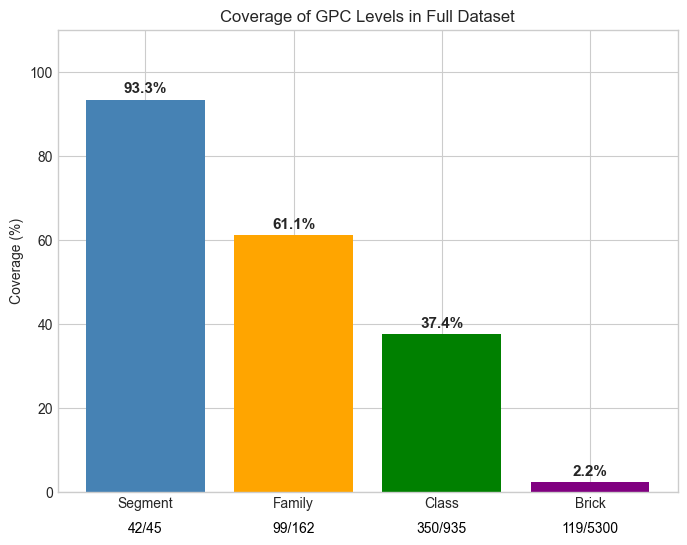

In [26]:

totals = {
    "Segment": df["SegmentTitle"].nunique(),
    "Family": df["FamilyTitle"].nunique(),
    "Class": df["ClassTitle"].nunique(),
    "Brick": df["BrickTitle"].nunique(),
}


actuals = {
    "Segment": full_df["segment"].nunique(),
    "Family": full_df["family"].nunique(),
    "Class": full_df["class"].nunique(),
    "Brick": full_df["brick"].nunique()
}


levels = list(totals.keys())
coverage = [actuals[l] / totals[l] * 100 for l in levels]

plt.figure(figsize=(8,6))
bars = plt.bar(levels, coverage, color=["steelblue", "orange", "green", "purple"])

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             f"{height:.1f}%", ha='center', va='bottom', fontsize=11, fontweight="bold")
    plt.text(bar.get_x() + bar.get_width()/2, -7,
             f"{actuals[levels[i]]}/{totals[levels[i]]}", ha='center', va='top', fontsize=10, color="black")

plt.ylim(0, 110)
plt.ylabel("Coverage (%)")
plt.title("Coverage of GPC Levels in Full Dataset")
plt.show()

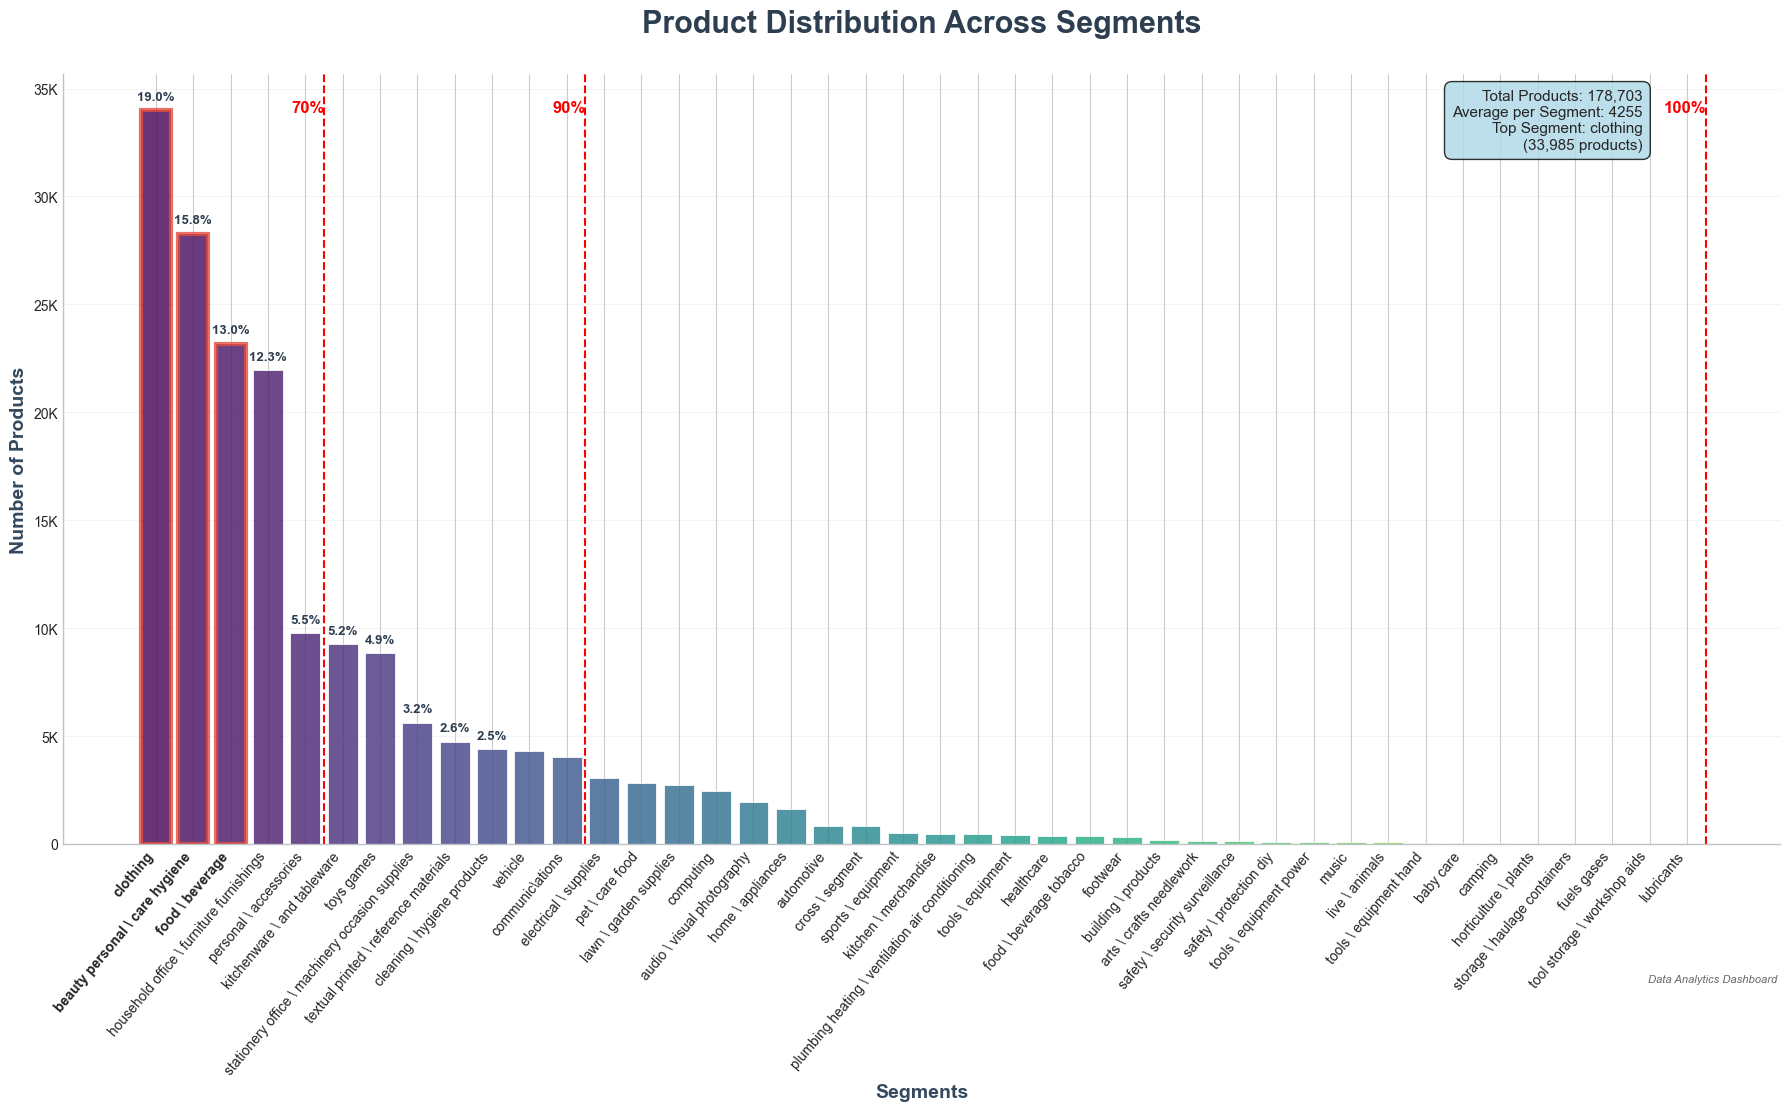

In [40]:
fig, ax = plt.subplots(figsize=(18, 10))

segment_counts = full_df["segment"].value_counts()

colors = plt.cm.viridis(np.linspace(0, 1, len(segment_counts)))

bars = ax.bar(range(len(segment_counts)), segment_counts.values, 
              color=colors, alpha=0.8, edgecolor='white', linewidth=0.7)

x_smooth = np.linspace(0, len(segment_counts)-1, 300)
# spl = make_interp_spline(range(len(segment_counts)), segment_counts.values, k=3)
# y_smooth = spl(x_smooth)

# ax.plot(x_smooth, y_smooth, color='red', linewidth=1, alpha=0.8, 
#         label='Distribution Curve')

def thousands_formatter(x, pos):
    return f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'

ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

ax.set_title('Product Distribution Across Segments', 
            fontsize=22, fontweight='bold', pad=30, color='#2c3e50')

ax.set_xlabel('Segments', fontsize=14, fontweight='600', color='#34495e')
ax.set_ylabel('Number of Products', fontsize=14, fontweight='600', color='#34495e')

cum_counts = segment_counts.cumsum()
total = segment_counts.sum()

cutoffs = {
    "70%": cum_counts[cum_counts <= total * 0.7].index[-1],
    "90%": cum_counts[cum_counts <= total * 0.9].index[-1],
    "100%": segment_counts.index[-1]
}

for pct, seg in cutoffs.items():
    idx = segment_counts.index.get_loc(seg)
    ax.axvline(idx + 0.5, color="red", linestyle="--", linewidth=1.5)
    ax.text(idx + 0.5, ax.get_ylim()[1]*0.95, pct,
            color="red", fontsize=12, fontweight="bold", ha="right")


segment_labels = []
for label in segment_counts.index:
    if len(label) > 11:
        words = label.split()
        if len(words) > 1:
            mid = len(words) // 2
            label = ' '.join(words[:mid]) + ' \\ ' + ' '.join(words[mid:])
        else:
            label = label[:8] + '\\' + label[8:]
    segment_labels.append(label)

ax.set_xticks(range(len(segment_counts)))
ax.set_xticklabels(segment_labels, rotation=50, ha='right', fontsize=10, 
                   verticalalignment='top')

ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, axis='y')
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#bdc3c7')
ax.spines['bottom'].set_color('#bdc3c7')

total = sum(segment_counts.values)

for i, (bar, value) in enumerate(zip(bars, segment_counts.values)):
    if i < 10:
        ratio = value / total * 100
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max(segment_counts.values) * 0.01,
            f'{ratio:.1f}%', 
            ha='center',
            va='bottom',
            fontsize=9.5,
            fontweight='bold',
            color='#2c3e50'
        )

top_3_indices = segment_counts.head(3).index
for i, segment in enumerate(segment_counts.index):
    if segment in top_3_indices:
        bars[i].set_edgecolor('#e74c3c')
        bars[i].set_linewidth(3)
        ax.get_xticklabels()[i].set_fontweight('bold')

total_products = segment_counts.sum()
avg_products = segment_counts.mean()
max_segment = segment_counts.index[0]
max_count = segment_counts.iloc[0]

textstr = f'Total Products: {total_products:,}\nAverage per Segment: {avg_products:.0f}\nTop Segment: {max_segment}\n({max_count:,} products)'
props = dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8)
ax.text(
    0.92, 0.98, textstr,
    transform=ax.transAxes,
    fontsize=11,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=props
)


plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

fig.text(0.99, 0.01, 'Data Analytics Dashboard', ha='right', va='bottom', 
         fontsize=8, style='italic', alpha=0.7)

plt.show()

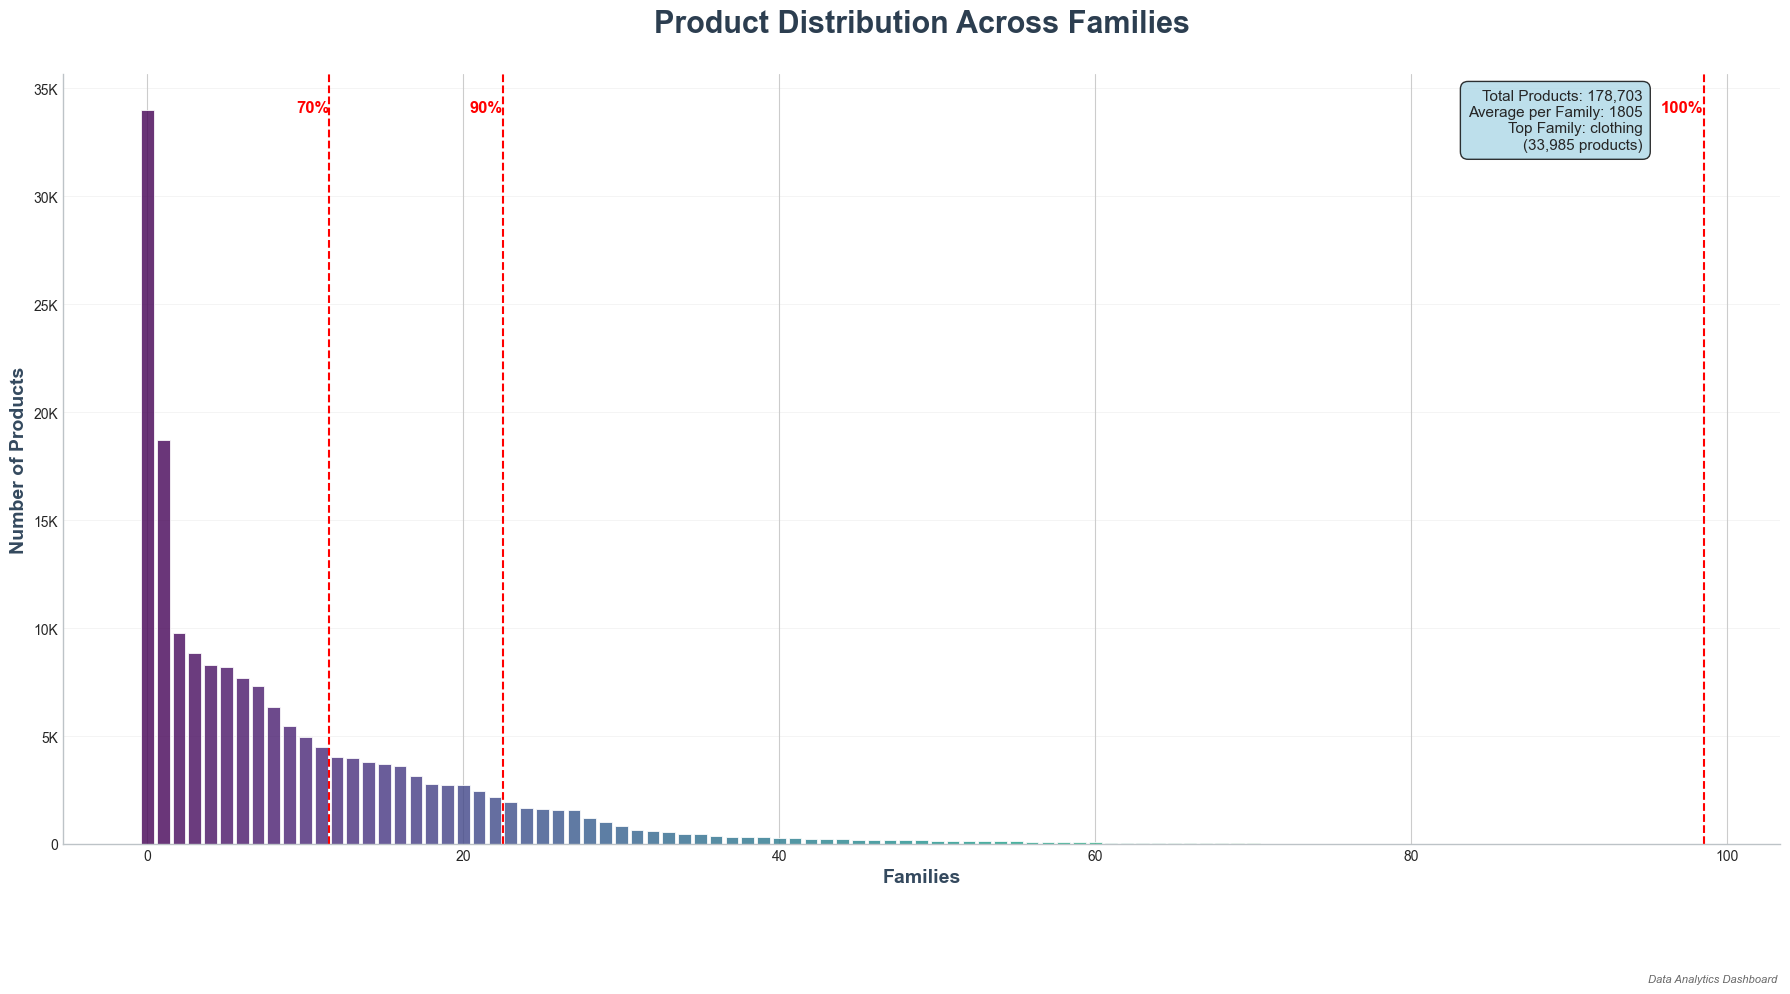

In [34]:
fig, ax = plt.subplots(figsize=(18, 10))

family_counts = full_df["family"].value_counts()

colors = plt.cm.viridis(np.linspace(0, 1, len(family_counts)))

bars = ax.bar(range(len(family_counts)), family_counts.values, 
              color=colors, alpha=0.8, edgecolor='white', linewidth=0.7)

# x_smooth = np.linspace(0, len(family_counts)-1, 300)
# spl = make_interp_spline(range(len(family_counts)), family_counts.values, k=3)
# y_smooth = spl(x_smooth)

# ax.plot(x_smooth, y_smooth, color='red', linewidth=1, alpha=0.8, 
#         label='Distribution Curve')

def thousands_formatter(x, pos):
    return f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'

cum_counts = family_counts.cumsum()
total = family_counts.sum()

cutoffs = {
    "70%": cum_counts[cum_counts <= total * 0.7].index[-1],
    "90%": cum_counts[cum_counts <= total * 0.9].index[-1],
    "100%": family_counts.index[-1]
}


for pct, seg in cutoffs.items():
    idx = family_counts.index.get_loc(seg)
    ax.axvline(idx + 0.5, color="red", linestyle="--", linewidth=1.5)
    ax.text(idx + 0.5, ax.get_ylim()[1]*0.95, pct,
            color="red", fontsize=12, fontweight="bold", ha="right")
    

ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

ax.set_title('Product Distribution Across Families', 
            fontsize=22, fontweight='bold', pad=30, color='#2c3e50')

ax.set_xlabel('Families', fontsize=14, fontweight='600', color='#34495e')
ax.set_ylabel('Number of Products', fontsize=14, fontweight='600', color='#34495e')

ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, axis='y')
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#bdc3c7')
ax.spines['bottom'].set_color('#bdc3c7')


total_products = family_counts.sum()
avg_products = family_counts.mean()
max_segment = family_counts.index[0]
max_count = family_counts.iloc[0]

textstr = f'Total Products: {total_products:,}\nAverage per Family: {avg_products:.0f}\nTop Family: {max_segment}\n({max_count:,} products)'
props = dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8)
ax.text(
    0.92, 0.98, textstr,
    transform=ax.transAxes,
    fontsize=11,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=props
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

fig.text(0.99, 0.01, 'Data Analytics Dashboard', ha='right', va='bottom', 
         fontsize=8, style='italic', alpha=0.7)
plt.show()

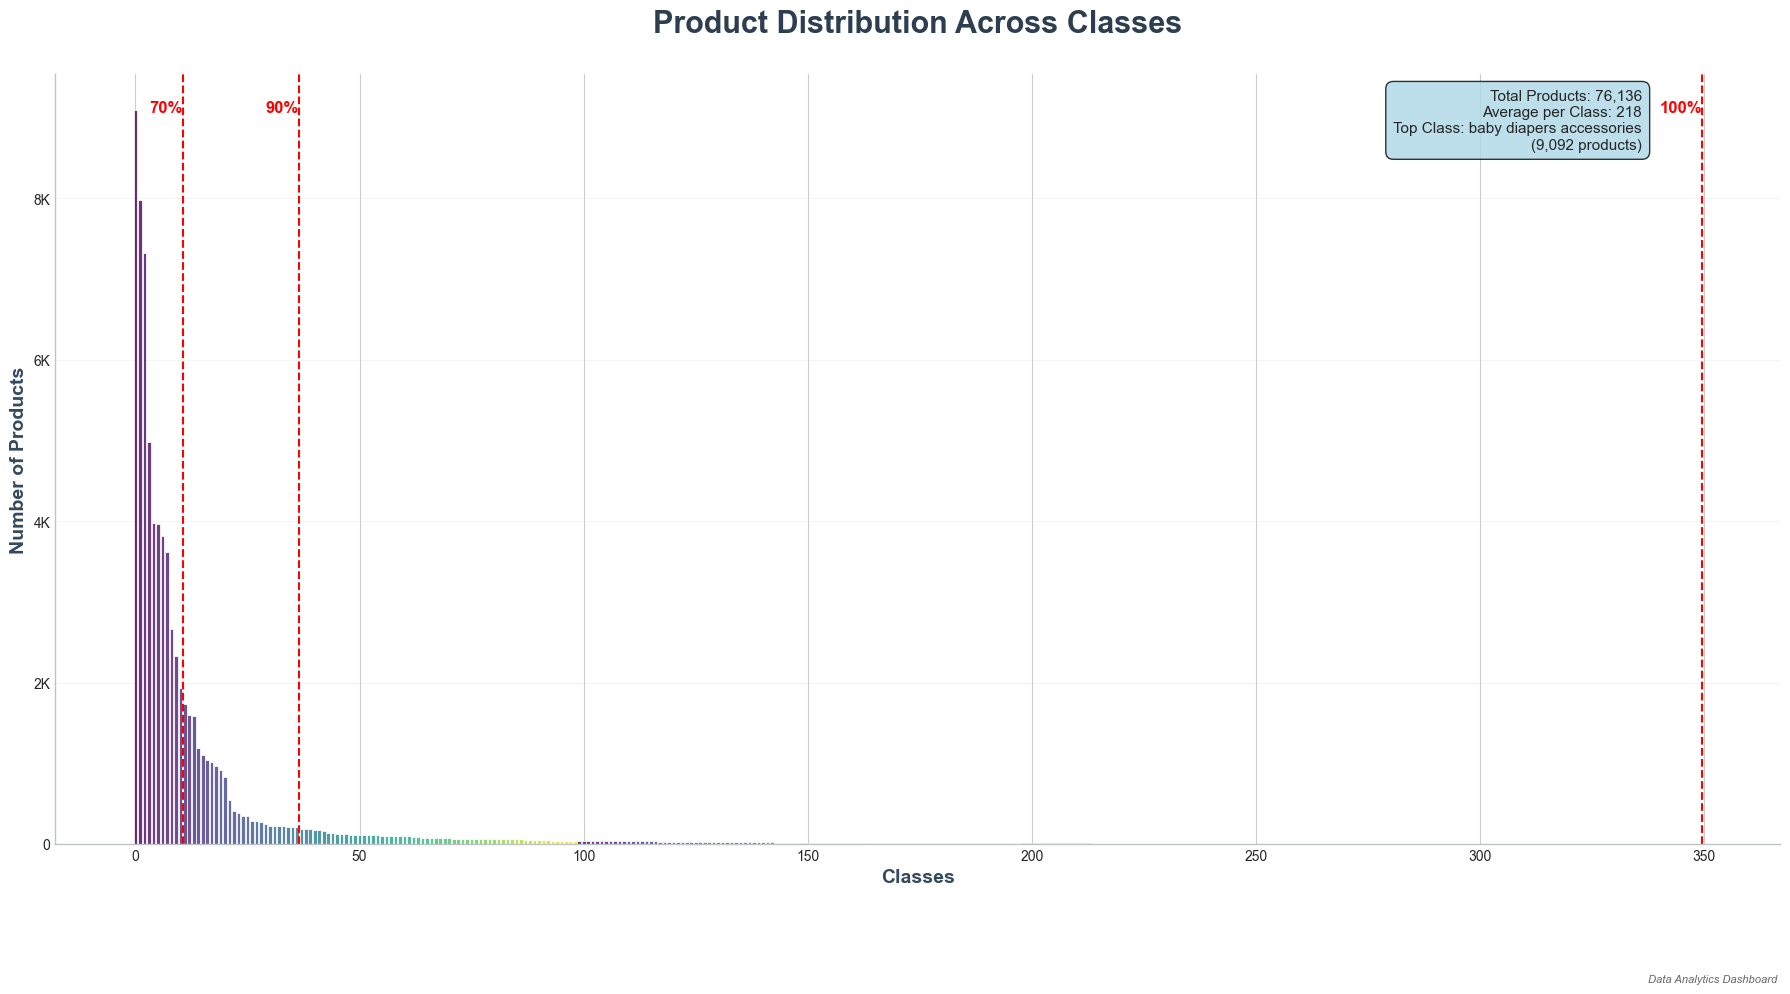

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))

class_counts = full_df["class"].value_counts()

colors = plt.cm.viridis(np.linspace(0, 1, len(family_counts)))

bars = ax.bar(range(len(class_counts)), class_counts.values, 
              color=colors, alpha=0.8, edgecolor='white', linewidth=0.7)

# x_smooth = np.linspace(0, len(family_counts)-1, 300)
# spl = make_interp_spline(range(len(family_counts)), family_counts.values, k=3)
# y_smooth = spl(x_smooth)

# ax.plot(x_smooth, y_smooth, color='red', linewidth=1, alpha=0.8, 
#         label='Distribution Curve')

def thousands_formatter(x, pos):
    return f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'

cum_counts = class_counts.cumsum()
total = class_counts.sum()

cutoffs = {
    "70%": cum_counts[cum_counts <= total * 0.7].index[-1],
    "90%": cum_counts[cum_counts <= total * 0.9].index[-1],
    "100%": class_counts.index[-1]
}


for pct, seg in cutoffs.items():
    idx = class_counts.index.get_loc(seg)
    ax.axvline(idx + 0.5, color="red", linestyle="--", linewidth=1.5)
    ax.text(idx + 0.5, ax.get_ylim()[1]*0.95, pct,
            color="red", fontsize=12, fontweight="bold", ha="right")
    

ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

ax.set_title('Product Distribution Across Classes', 
            fontsize=22, fontweight='bold', pad=30, color='#2c3e50')

ax.set_xlabel('Classes', fontsize=14, fontweight='600', color='#34495e')
ax.set_ylabel('Number of Products', fontsize=14, fontweight='600', color='#34495e')

ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, axis='y')
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#bdc3c7')
ax.spines['bottom'].set_color('#bdc3c7')


total_products = class_counts.sum()
avg_products = class_counts.mean()
max_segment = class_counts.index[0]
max_count = class_counts.iloc[0]

textstr = f'Total Products: {total_products:,}\nAverage per Class: {avg_products:.0f}\nTop Class: {max_segment}\n({max_count:,} products)'
props = dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8)
ax.text(
    0.92, 0.98, textstr,
    transform=ax.transAxes,
    fontsize=11,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=props
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

fig.text(0.99, 0.01, 'Data Analytics Dashboard', ha='right', va='bottom', 
         fontsize=8, style='italic', alpha=0.7)
plt.show()

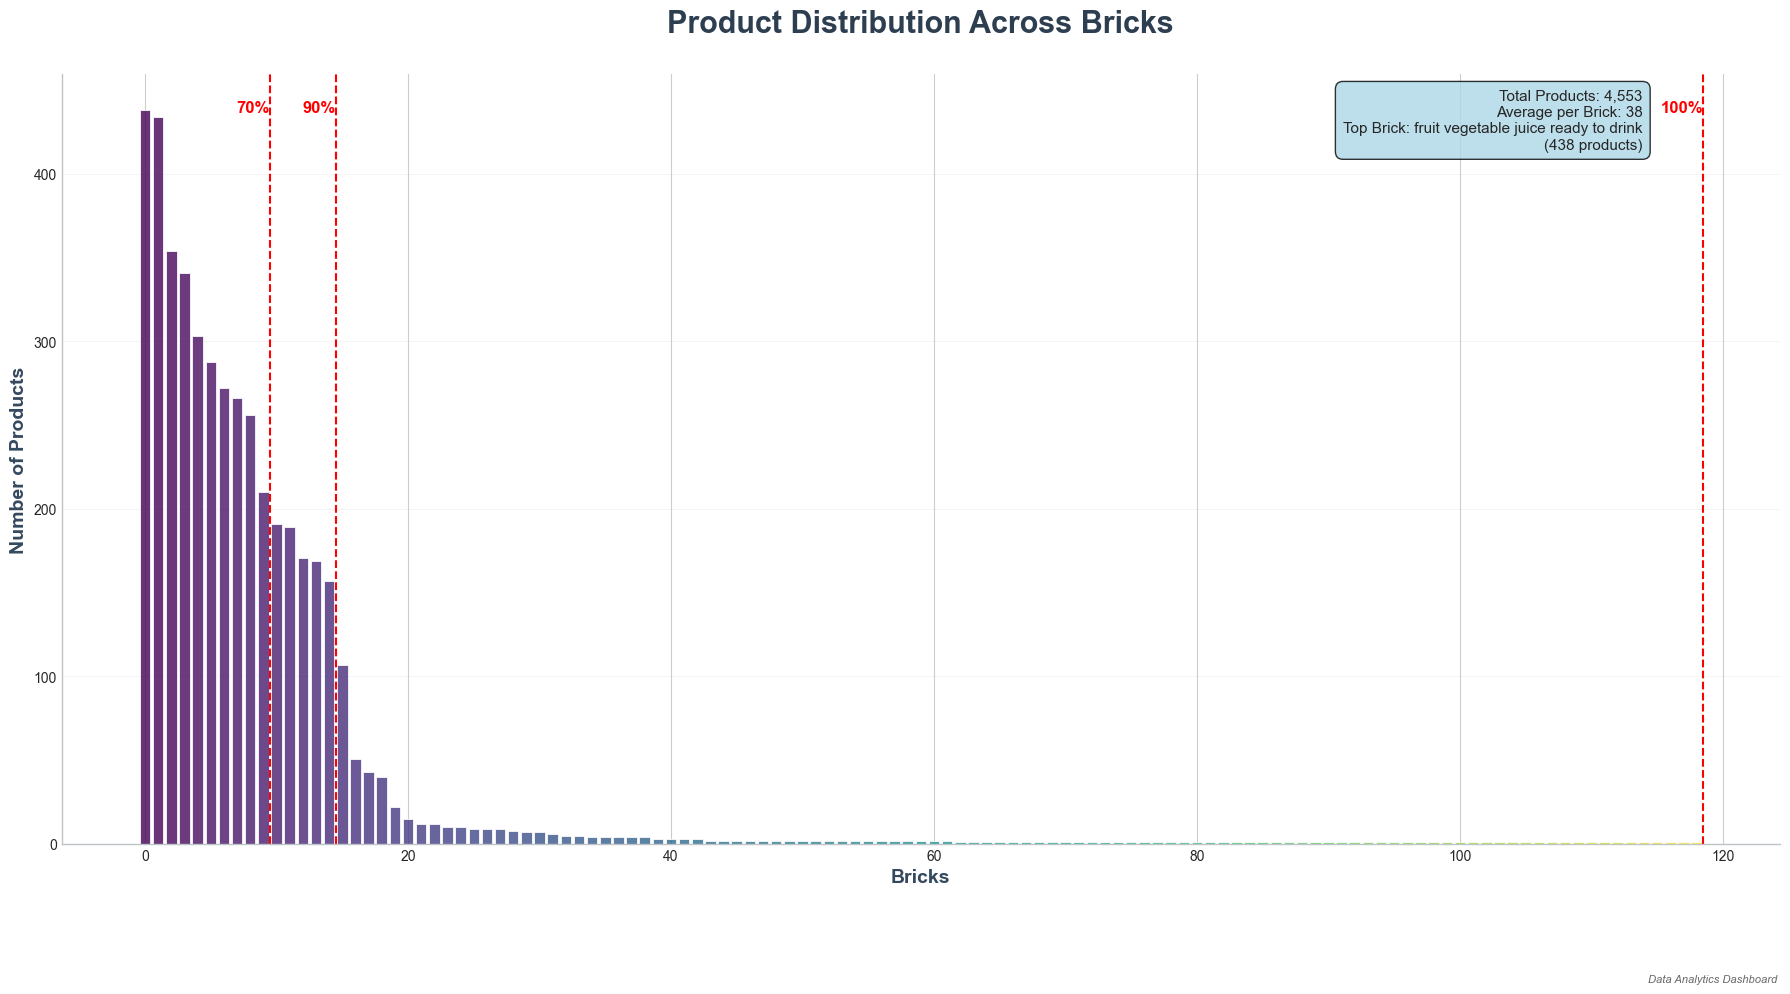

In [33]:
fig, ax = plt.subplots(figsize=(18, 10))

brick_counts = full_df["brick"].value_counts()

colors = plt.cm.viridis(np.linspace(0, 1, len(brick_counts)))

bars = ax.bar(range(len(brick_counts)), brick_counts.values, 
              color=colors, alpha=0.8, edgecolor='white', linewidth=0.7)

# x_smooth = np.linspace(0, len(family_counts)-1, 300)
# spl = make_interp_spline(range(len(family_counts)), family_counts.values, k=3)
# y_smooth = spl(x_smooth)

# ax.plot(x_smooth, y_smooth, color='red', linewidth=1, alpha=0.8, 
#         label='Distribution Curve')

def thousands_formatter(x, pos):
    return f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'

cum_counts = brick_counts.cumsum()
total = brick_counts.sum()

cutoffs = {
    "70%": cum_counts[cum_counts <= total * 0.7].index[-1],
    "90%": cum_counts[cum_counts <= total * 0.9].index[-1],
    "100%": brick_counts.index[-1]
}


for pct, seg in cutoffs.items():
    idx = brick_counts.index.get_loc(seg)
    ax.axvline(idx + 0.5, color="red", linestyle="--", linewidth=1.5)
    ax.text(idx + 0.5, ax.get_ylim()[1]*0.95, pct,
            color="red", fontsize=12, fontweight="bold", ha="right")
    

ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

ax.set_title('Product Distribution Across Bricks', 
            fontsize=22, fontweight='bold', pad=30, color='#2c3e50')

ax.set_xlabel('Bricks', fontsize=14, fontweight='600', color='#34495e')
ax.set_ylabel('Number of Products', fontsize=14, fontweight='600', color='#34495e')


ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, axis='y')
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#bdc3c7')
ax.spines['bottom'].set_color('#bdc3c7')


total_products = brick_counts.sum()
avg_products = brick_counts.mean()
max_segment = brick_counts.index[0]
max_count = brick_counts.iloc[0]

textstr = f'Total Products: {total_products:,}\nAverage per Brick: {avg_products:.0f}\nTop Brick: {max_segment}\n({max_count:,} products)'
props = dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8)
ax.text(
    0.92, 0.98, textstr,
    transform=ax.transAxes,
    fontsize=11,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=props
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

fig.text(0.99, 0.01, 'Data Analytics Dashboard', ha='right', va='bottom', 
         fontsize=8, style='italic', alpha=0.7)
plt.show()

In [28]:
full_df.head()

,Unnamed: 0,product_name,description,segment,family,class,brick,source,text,dedup_key
0,0,Sterling Silver Angel Charm,This little angel charm is just heavenly,personal accessories,personal accessories,jewellery,NaN,MWPD_FULL,sterling silver angel charm,sterling silver angel charm
1,1,HP Pavilion 23xi 58.40 cm (23�) IPS Monitor,"Share photos, videos, and games with everyone ...",computing,computers video games,computer video game peripherals,NaN,MWPD_FULL,hp pavilion 23xi 58.40 cm 23 ips monitor,hp pavilion 23xi 58 40 cm 23 ips monitor
2,2,East Carolina Pirates Ladies Personalized Bask...,Feel like a bona fide member of East Carolina ...,clothing,clothing,upper body wear tops,NaN,MWPD_FULL,east carolina pirates ladies personalized bask...,east carolina pirates ladies personalized bask...
3,3,"Tekonsha 90195 P3 Electric Brake Control, 1-4 ...",Receive free shipping on this item. Enter coup...,automotive,automotive accessories and maintenance,automotive maintenance repair,NaN,MWPD_FULL,tekonsha 90195 p3 electric brake control 1-4 t...,tekonsha 90195 p3 electric brake control 1 4 t...
4,4,RN-XV WiFly Module - Wire Antenna,Description: The RN-XV module by Roving Networ...,electrical supplies,electronic communication components,electronic communication components,NaN,MWPD_FULL,rn-xv wifly module - wire antenna,rn xv wifly module wire antenna


In [11]:
td_db = TeradataDatabase()
td_db.connect()

In [12]:
full_df = full_df.applymap(
    lambda x: x.encode("utf-8", "ignore").decode("utf-8") if isinstance(x, str) else x
)

In [13]:
full_df = full_df.applymap(
    lambda x: x.encode("ascii", "replace").decode("ascii") if isinstance(x, str) else x
)


In [14]:
copy_to_sql(full_df, "full_dataset_un_cleaned", "demo_user", if_exists="replace")